# Домашнее задание 2.2. Обучение сетей на Pytorch

В этом задании нужно:
1. Написать свою сеть на Pytorch по варианту
2. Обучить ее и сравнить результаты с дообученной сетью из зоопарка моделей
3. Поставить ряд экспериментов, показывающих насколько гиперпараметры обучения влияют на результат

**Варианты архитектуры сверточной сети:**
Вариант на ваш выбор - напишите его в чат. Не более двух человек на один вариант
1. Resnet v2
2. Inception Google LeNet
3. MobileNetv2 (Коростинский, Глаз)
4. SE Net
5. DenseNet
6. Conv Mixer
7. RepVGG

## Имплементация сети на Pytorch

Здесь вы должны написать модель, выданную вам по варианту.
Для этого нужно:
1. Не забывать про использоватие блоков nn.Module, nn.Sequential, nn.ModuleList
2. Использовать материалы из предыдущих семинаров

В качестве примера ниже реализован макет для модели, состоящей из блоков.

## Архитектура Dense слоя сети DenseNet. 
В нем все  признаки с каждого слоя конкатенируются и передаются во все следующие.

![image.png](DenseNet.jpg)

In [1]:
import torch
from torch import nn
from collections import OrderedDict

In [2]:
# Input: (N, C, H, W) tensor
# Layer: combination of (BN2D + ReLu + Conv2D1x1 + BN2D + ReLu + Conv2D3x3) layers
# Arch: each layer l accepts k_0 + k * (l - 1) feature maps
# There is a bottleneck in each layer: each Conv2D1x1 reduces number of chanels to bn_size
# This is needed because first convolution might have high num_input_features 
#   because of data from the previous layers:
# Example of how C changes throughout the network:
# 	layer 1: (input) -> (bn_size * k) -> (k) 
#		 		|						 |
# 		 		|						 V
# 	layer 2: 	--------------> (input + k) -> (bn_size * k) -> (k)
#   layer 3:    (input + k + k) -> (bn_size * k) -> (k)

# Size change:
#   (h, w) -> (h, w)
class DenseLayer(nn.Module):
	def __init__(self, num_input_features : int, bottle_neck_dim : int, num_out_features : int) -> None:
		super().__init__()
		self.bottle_neck = nn.Sequential(OrderedDict([ 
			('norm1', nn.BatchNorm2d(num_input_features)),
			('relu1', nn.ReLU()),
			('conv1', nn.Conv2d(num_input_features, bottle_neck_dim,
							kernel_size=1, stride=1, bias=False))]))
		
		self.conv = nn.Sequential(OrderedDict([
			('norm2', nn.BatchNorm2d(bottle_neck_dim)),
			('relu2', nn.ReLU()),
			# Pudding is needed in order to match concatinating outputs
			('conv2', nn.Conv2d(bottle_neck_dim, num_out_features,
							kernel_size=3, stride=1, padding=1, bias=False)),
		]))
		
	def forward(self, input : torch.tensor) -> torch.tensor:
		bottle_neck_output = self.bottle_neck(input)
		return self.conv(bottle_neck_output)

class DenseBlock(nn.Module):
	def __init__(self, num_input_features : int, num_layers : int, k : int, bn_size : int) -> None:
		super().__init__()
		self.dense_blocks = nn.Sequential()
		cur_num_input_features = num_input_features
		for l in range(num_layers):
			layer = DenseLayer(num_input_features=cur_num_input_features, 
							   bottle_neck_dim=bn_size, 
							   num_out_features=k)
			self.dense_blocks.add_module(f"denseblock{l}", layer)
			cur_num_input_features = (l + 1) * k
		
	def forward(self, input : torch.tensor) -> torch.tensor:
		prev_features = None
		for layer in self.dense_blocks:
			output = layer(input)
			# dim=1 is a dimension of blocks
			if prev_features is not None:
				input = torch.cat((prev_features, output), dim=1)
			else:
				input = output
			prev_features = input
		return input

Архитектура из оригинальной статьи (после кажой свертки стоит BatchNorm и ReLu):
- 7 × 7 conv, stride 2
- 3 × 3 max pool, stride 2
- dense layer x 6
- 1 × 1 conv
- 2 × 2 average pool, stride 2
- dense layer x 12
- 1 × 1 conv
- 2 × 2 average pool, stride 2
- dense layer x 24
- 1 × 1 conv
- 2 × 2 average pool, stride 2
- dense layer x 16
- 1 × 1 conv
- 7 × 7 global average pool
- fully-connected, softmax

Она была рассчитана на картинки большего размера. Для работы с картинками 32х32 была разработана архитектура:
- (32, 32)
- 7 × 7 conv, stride 1 -> (26, 26)
- 3 × 3 max pool, stride 2 -> (12, 12)
- dense layer x 6 -> (12, 12)
- 1 × 1 conv -> (12, 12)
- 2 × 2 average pool, stride 1 -> (6, 6)
- dense layer x 12 -> (6, 6)
- 1 × 1 conv -> (6, 6)
- 6 × 6 global average pool -> (1, 1)

In [3]:
class DenseNet(nn.Module):
    def __init__(self, num_input_features : int, num_classes : int,
                 init_conv_num_features=24, k=4, bn_size=16, compression=0.5) -> None:
        super().__init__()

        self.blocks = nn.Sequential(OrderedDict([
          ('conv0', nn.Conv2d(num_input_features, init_conv_num_features, 
                              kernel_size=(7, 7), stride=1)),
          ('norm0', nn.BatchNorm2d(init_conv_num_features)),
          ('relu0', nn.ReLU()),
          ('maxpool', nn.MaxPool2d(kernel_size=(3, 3), stride=2))
		]))

        dense_sizes = [6, 12]
        dense_input_features_size = init_conv_num_features
        block_num = 1
        for dense_block_size in dense_sizes:
            self.blocks.add_module(f"dense{block_num}", 
                DenseBlock(num_input_features=dense_input_features_size, 
                            num_layers=dense_block_size, k=k, bn_size=bn_size))
            
            conv_input_feature_size = k * dense_block_size
            conv_output_feature_size = int(conv_input_feature_size * compression)
            self.blocks.add_module(f"compress{block_num}",
				nn.Conv2d(in_channels=conv_input_feature_size,
              			  out_channels=conv_output_feature_size,
                          kernel_size=(1, 1)))
            
            self.blocks.add_module(f"norm{block_num}", nn.BatchNorm2d(conv_output_feature_size))
            self.blocks.add_module(f"relu{block_num}", nn.ReLU())
            # last pooling is 7x7
            if block_num != len(dense_sizes):
                self.blocks.add_module(f"avgpool{block_num}", nn.AvgPool2d(kernel_size=(2, 2), stride=1))
            dense_input_features_size = conv_output_feature_size
            block_num += 1			

        # Classification
        self.blocks.add_module('globavgpool', nn.AvgPool2d(kernel_size=(6, 6)))
        self.classifier = nn.Linear(dense_input_features_size, num_classes)

    def forward(self, x):
        output = self.blocks(x)
        # We don't want to flatten batchб so there is a start_dim=1
        return self.classifier(torch.flatten(output, start_dim=1))

In [4]:
# если вы написали модель правильно
# эта ячейка должна выполниться
num_input_features = 3
model = DenseNet(num_input_features, num_classes=10)

In [5]:
model

DenseNet(
  (blocks): Sequential(
    (conv0): Conv2d(3, 24, kernel_size=(7, 7), stride=(1, 1))
    (norm0): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU()
    (maxpool): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    (dense1): DenseBlock(
      (dense_blocks): Sequential(
        (denseblock0): DenseLayer(
          (bottle_neck): Sequential(
            (norm1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU()
            (conv1): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (conv): Sequential(
            (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU()
            (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
        )
        (denseblock1): DenseLayer(
          (bottle_neck): S

In [6]:
# Если сделать картинк услишком большой, то она не свернется в 32x1x1 в конце
sample_tensor = torch.randn(1, num_input_features, 32, 32)
model(sample_tensor)

tensor([[0.1208, 0.0835, 0.1385, 0.2480, 0.1324, 0.2753, 0.0078, 0.0163, 0.4208,
         0.0054]], grad_fn=<AddmmBackward0>)

### Как проводить эксперименты

"Neural net training is a leaky abstraction" - Andrej Karpathy

Знания теории, архитектур, оптимизаторов порой недостаточно для получения хорошей модели - значит, пришла пора подбора гиперпараметров.  
В таких случаях может помочь не *model-centric*, а *data-centric* подход: переразметить данные, поменять аугментации, докинуть новые.

**Но во всех этих случаях правильно организовать эксперименты**



**Перед началом:**
Убедитесь, что у вас есть хороший и адекватный бейзлайн
1. Сначала вместо самописных моделей берите архитектуры из известных репозиториев (torchvision, timm, mmdetection, huggingface etc)
2. Эти архитектуры должны быть стандартными для вашей задачи. То есть, для задач компьютерного зрения (классификации, детекции, сегментации) - ResNet, для обработки языков - трансформер.
3. Не придумывайте сложные пайплайны обучения - Adam + LR без расписания, предобработка входа - такая же как у предобученной модели
4. Первые пробные запуски делайте на подвыборках, тестовых датасетах


**Снизьте число факторов влияния**:
1. Баги могут быть в разных частях: в модели, обучении, загрузке данных, проверке качества. Сначала избавьтесь от эффекта случайности и зафиксируйте seed и попробуйте поставить determenistic поведение
2. Визуализируйте *все*: метрики, лоссы, градиенты, примеры работы модели, работу аугментаций
3. Пишите unit-тесты. Даже небольшие!
4. Сохраняйте чекпоинты. Не только best и last. Полезно брать чекпоинты каждые несколько итераций
5. При проведении экспериментов вносите **только одно изменение за раз**.


Более полные и точные рецепты можете прочитать [здесь](https://github.com/puhsu/dl-hse/blob/main/week01-intro/lecture-best-practices.pdf)

## Обучение и подбор гиперпараметров



> **Гиперпараметры** отличаются от **параметров** следующим:
> * Они не могут обучаться с помощью градиентного спуска: например, выбор оптимизатора, learning rate, аугментаций, сам подбор архитектуры и пайплайна можно считать за гиперпараметры. Иначе говоря, все, что мы не можем включить в нашу end-to-end модель, чтобы обучать это через функцию потерь, является гиперпараметром
> * Часто гиперпараметры подбирают на валидационной выборке (точнее, если их подбор уж очень важен, для них создают специальную выборку, которая называется *dev выборка*): например, weight decay
> * Гиперпараметры бывают дискретными и без отношения порядка: например, выбор расписания для lr, а также выбор момента шага расписания - можно делать шаг на каждом шаге оптимизатора, можно на каждой эпохе



**Вопрос**: почему weight decay лучше подбирать на валидационной выборке? Можно ли его подбирать на обучающей? Если можно, то как?

**Ответ** weight decay (L2 регуляризация) подбирается на валидационной выборке потому, что переобучение легче всего определяяется именно там. Переобучение можно попробовать определить по тренировочной выборке, если учитывать не текущее значение функции потерь а ее динамику за несколько эпох. В этом случае можно накладывать штрафы на веса модели.

Чтобы не писать собственный train loop, мы будем использовать **Pytorch Lightning**.   

Это не самый лучший фреймворк для обучения - в нем множество багов, которые особенно любят проявлять себя в сложных моделях, обучаемых в low-precision с параллелизмом.  

Но большая часть популярных фреймворков организована именно так - train loop скрыт от глаз пользователя. Поэтому полезно посмотреть это на таком простом примере, как Pytorch Lightning

In [7]:
! pip install pytorch_lightning >> None

In [8]:
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

In [9]:
torch.random.manual_seed(42)
pl.seed_everything(42)

Seed set to 42


42

In [10]:
# self.log() logs into Tenserboard

class ConvModelPL(pl.LightningModule):
  def __init__(self, model, loss, lr, weight_decay):
    super().__init__()
    self.model = model
    self.loss = loss
    self.lr = lr
    self.weight_decay = weight_decay

    self.validation_step_outputs = []

  def training_step(self, batch, batch_idx):
    x, y = batch
    pred = self.model(x)
    loss = self.loss(pred, y)
    self.log("train_loss", loss)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    pred = self.model(x)
    loss = self.loss(pred, y)
    # Calculating accuracy
    pred = torch.argmax(pred, dim=1)
    train_acc = torch.sum(pred == y)
    metric = train_acc / float(len(y))
    self.validation_step_outputs.append(metric)
    self.log("val_loss", loss)
    return metric

  def on_validation_epoch_end(self):
    total_metric = torch.stack(self.validation_step_outputs).mean()
    self.log("val_epoch_acc", total_metric)


  def configure_optimizers(self):
      optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
      scheduler = {
            'scheduler': torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=10),
            'interval': 'step',
            'frequency': 1,
        }
      return [optimizer], [scheduler]

In [11]:
model = DenseNet(num_input_features=3, num_classes=10)
model_pl = ConvModelPL(model, loss=nn.CrossEntropyLoss(), lr=1e-4, weight_decay=1e-6)

Дальше создадим датасеты и даталоадеры.
Опять же, вам нужно написать более точную конфигурацию: подобрать аугментации для baseline, batch_size, параметры даталоадера

In [12]:
import torchvision
from torchvision import transforms

batch_size = 32
workers = 1

# вспомните, что вы можете использовать не только аугментации из torchvision
# но и из albumentations и, если уж совсем хотите заморочиться, nvidia dali
# прочитайте вот эту статью, возможно, аугментации из нее могут вам помочь
# https://openaccess.thecvf.com/content_CVPR_2019/papers/He_Bag_of_Tricks_for_Image_Classification_with_Convolutional_Neural_Networks_CVPR_2019_paper.pdf
transform_to_tensor = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transform_to_tensor
train_transform = transforms.Compose([transform_to_tensor, 
                                      transforms.RandomHorizontalFlip(p=0.1)])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)


Files already downloaded and verified
Files already downloaded and verified


In [13]:

# есть несколько способов ускорения даталоадера

# главный из них - ставить pin_memory, когда вы работаете с gpu
# дело в том, что программы на host'е работает с логической памятью, которая называется paged memory,
# она связана с физической с помощью таблицы - page table
# когда физической памяти не хватает, страницы из page memory выгружаются (page out) на другие носители (например, на ssd)
# получается, paged memory нестабильна и может быть разбросана по разным физическим устройствам
# чтобы скопировать данные на device, сначала данные из paged memory копируются в page-locked memory,
# и только затем на device
# можно избежать такого: сразу выделять память в page-locked memory
# именно это и делает аргумент pin_memory=True
# https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/

# также если у вашего трейнлупа нет точек синхронизации (напимер, print, logging, перемещение на cpu)
# то можно ставить data = data.to('cuda:0', non_blocking=True) при отправлении данных
# https://discuss.pytorch.org/t/should-we-set-non-blocking-to-true/38234/3

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


input shape torch.Size([3, 32, 32])
label example: 6


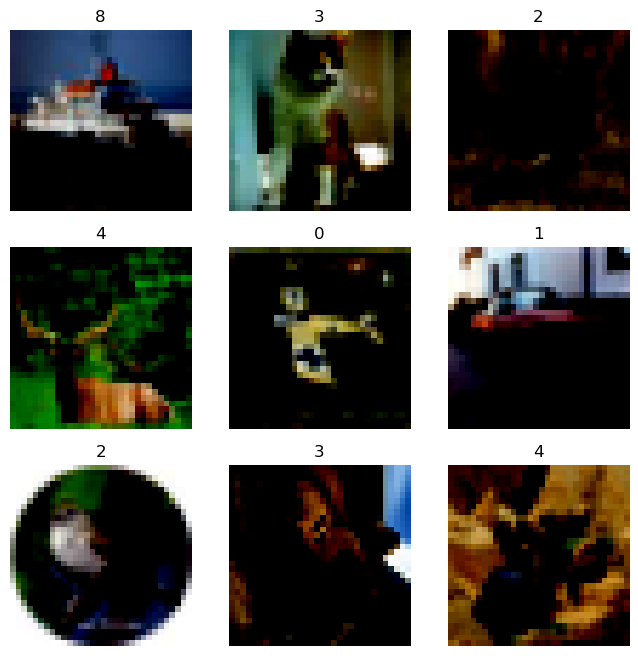

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    img = img.permute(1, 2, 0)
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
print(f"input shape {train_set[0][0].shape}")
print(f"label example: {train_set[0][1]}")
plt.show()

In [15]:
labels = set()
for img, label in train_set:
    labels.add(label)
number_of_labels = len(labels)
print(f"number of labels: {number_of_labels}")

number of labels: 10


**Вопрос:** на что влияет аргумент num_workers в DataLoader? Каким его можно ставить?

**Ответ** num_workers - количество потоков, которые загружают батчи в память. Это ускоряет обучение сети потому, что перенос данных - значительная часть времени обучения. Его можно выставить каким угодно, но при значении боьше чем количество хартов компьютера они не будут радотать по-настоящему параллельно. Если память компьютера являетсся бутылочным горлом, то повыышение num_workers не ускорит программу.

In [16]:
# а теперь можно запускать обучение и смотреть метрики и графики
# просмотр графиков вы должны вставить сами

# чтобы запустить на маке
# напишите device='mps'
device = 'cuda'

# здесь только пробный запуск
# очевидно, вы должны изменить параметры limit_train_batches и max_epochs
# когда будете делать более сложные эксперименты
#trainer = pl.Trainer(limit_train_batches=100, max_epochs=20)
#trainer.fit(model_pl, train_loader, test_loader)

Попробуйте получить хороший бейзлайн по рекомендациям выше.  
После обучения модели подберите гиперпараметры и, если вы этого захотите, немного измените архитектуру модели так, чтобы добиться более высокой метрики.

In [17]:
# baseline model
model = DenseNet(num_input_features=3, num_classes=number_of_labels)
model_pl = ConvModelPL(model, loss=nn.CrossEntropyLoss(), lr=1e-4, weight_decay=1e-6)

In [18]:
tb_logger = pl_loggers.TensorBoardLogger(save_dir="./log/densenet-baseline")
trainer = pl.Trainer(max_epochs=40, logger=tb_logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [19]:
trainer.fit(model_pl, train_loader, test_loader)

2024-11-13 00:33:07.169703: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-13 00:33:08.302720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DenseNet         | 22.8 K | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
22.8 K    Trainable params
0         Non-trainable params
22.8 K    Total params
0.091     Total estimated model params size (MB)
182       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/azor/.conda/envs/ML/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/azor/.conda/envs/ML/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

За 40 эпох нейросеть не дообучилась. Конечное значение accuracy на валидационной выборке:
`0.54`

Проведем подбор гиперпараметров на меньшем числе эпох:

In [20]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'k': [2, 16],
    'lr': [1e-3, 1e-5],
    'weight_decay': [1e-5, 1e-7]
}
grid = ParameterGrid(param_grid)

In [21]:
from tqdm.auto import tqdm

results = []
for params_id in tqdm(range(len(grid))):
    params = grid[params_id]
    k = params['k']
    lr = params['lr']
    weight_decay = params['weight_decay']

    model = DenseNet(num_input_features=3, num_classes=number_of_labels, 
                    k=k)
    model_pl = ConvModelPL(model, loss=nn.CrossEntropyLoss(), lr=lr, weight_decay=weight_decay)
    tb_logger = pl_loggers.TensorBoardLogger(save_dir=f"./log/k-{k}-lr-{lr}-dec-{weight_decay}")
    trainer = pl.Trainer(max_epochs=12, logger=tb_logger)   

    trainer.fit(model_pl, train_loader, test_loader)
    results.append((params, trainer.callback_metrics['val_loss']))

  0%|          | 0/8 [00:00<?, ?it/s]

/tmp/ipykernel_4147/811893383.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  params = grid[params_id]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DenseNet         | 13.4 K | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
13.4 K    Trainable params
0         Non-trainable params
13.4 K    Total params
0.053     Total estimated model params size (MB)
182       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/azor/.conda/envs/ML/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/azor/.conda/envs/ML/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DenseNet         | 13.4 K | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
13.4 K    Trainable params
0         Non-trainable params
13.4 K    Total params
0.053     Total estimated model params size (MB)
182       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DenseNet         | 13.4 K | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
13.4 K    Trainable params
0         Non-trainable params
13.4 K    Total params
0.053     Total estimated model params size (MB)
182       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DenseNet         | 13.4 K | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
13.4 K    Trainable params
0         Non-trainable params
13.4 K    Total params
0.053     Total estimated model params size (MB)
182       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DenseNet         | 94.7 K | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
94.7 K    Trainable params
0         Non-trainable params
94.7 K    Total params
0.379     Total estimated model params size (MB)
182       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DenseNet         | 94.7 K | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
94.7 K    Trainable params
0         Non-trainable params
94.7 K    Total params
0.379     Total estimated model params size (MB)
182       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DenseNet         | 94.7 K | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
94.7 K    Trainable params
0         Non-trainable params
94.7 K    Total params
0.379     Total estimated model params size (MB)
182       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DenseNet         | 94.7 K | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
94.7 K    Trainable params
0         Non-trainable params
94.7 K    Total params
0.379     Total estimated model params size (MB)
182       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.


In [22]:
best_params = sorted(results, key=lambda x: x[1])[0]
print(f'Best parameters: {best_params[0]}, Validation Loss: {best_params[1]}')

Best parameters: {'weight_decay': 1e-05, 'lr': 0.001, 'k': 16}, Validation Loss: 0.7935603260993958


Из шрафиков видно, что наибольшее влияние на результат оказывет параметр k. Полберем только этот параметр.

In [31]:
param_grid = {
    'k': [16, 24, 32]
}
grid = ParameterGrid(param_grid)

In [32]:
results = []
for params_id in tqdm(range(len(grid))):
    params = grid[params_id]
    k = params['k']

    model = DenseNet(num_input_features=3, num_classes=number_of_labels, 
                    k=k)
    model_pl = ConvModelPL(model, loss=nn.CrossEntropyLoss(), lr=0.001, weight_decay=1e-05)
    tb_logger = pl_loggers.TensorBoardLogger(save_dir=f"./log/only-k-{k}")
    trainer = pl.Trainer(max_epochs=12, logger=tb_logger)   

    trainer.fit(model_pl, train_loader, test_loader)
    results.append((params, trainer.callback_metrics['val_loss']))

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_4147/157379545.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  params = grid[params_id]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DenseNet         | 94.7 K | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
94.7 K    Trainable params
0         Non-trainable params
94.7 K    Total params
0.379     Total estimated model params size (MB)
182       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/azor/.conda/envs/ML/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/azor/.conda/envs/ML/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DenseNet         | 157 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
157 K     Trainable params
0         Non-trainable params
157 K     Total params
0.628     Total estimated model params size (MB)
182       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DenseNet         | 230 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
230 K     Trainable params
0         Non-trainable params
230 K     Total params
0.924     Total estimated model params size (MB)
182       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.


In [33]:
best_params = sorted(results, key=lambda x: x[1])[0]
print(f'Best parameters: {best_params[0]}, Validation Loss: {best_params[1]}')

Best parameters: {'k': 32}, Validation Loss: 0.7367120981216431


In [34]:
# You might run this in terminal and visit the site http://127.0.0.1:6006/#timeseries
#%tensorboard --bind_all --logdir lightning_logs/

## Transfer Learning и Fine-Tune

Для многих прикладных задач не существует больших датасетов с хорошей разметкой. Поэтому распространенным приемом является тренировка на похожем, но большом датасете и доучивание сети на целевом.

Такой прием называют **Transfer Learning** или **Fine-tuning**.

В сверточных сетях для классификации выделяют две части:
1. Тело сети (backbone, feature extractor) - это набор сверток и пулингов (convolutions and poolings)
2. Голову (head) - это MLP (набор полносвязных слоев) после которых делается softmax и получаются вероятности разных классов.

Вычислительно простым вариантом finetuning является переучивание головы сети. Также можно фиксировать какие-то первый слои

In [35]:
from torchvision import models

model = models.resnet18(pretrained=True)

# кроме torchvision очень известен репозиторий pytorch-image-models
# !pip install timm >> None
# import timm
# model = timm.create_model('resnet18', pretrained=True)

/home/azor/.conda/envs/ML/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/azor/.conda/envs/ML/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
# заморозим слои
for param in model.parameters():
  param.requires_grad = False

In [37]:
# 10 - число наших классов
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)
# теперь requires_grad=True только у model.fc

**Вопрос:** почему нужно использовать lr warmup для fine-tune предобученной модели?

### Дообучение головы


In [38]:
model_pl = ConvModelPL(model, loss=nn.CrossEntropyLoss(), lr=1e-4, weight_decay=1e-6)

In [39]:
tb_logger = pl_loggers.TensorBoardLogger(save_dir="./log/resnet-only-head")
trainer = pl.Trainer(max_epochs=15, logger=tb_logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [40]:
trainer.fit(model_pl, train_loader, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | ResNet           | 11.2 M | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
5.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# осталось лишь заметить, что пайплайн обучения уже написан - он хранится в model_pl
# вам осталось его только запустить
# проведите несколько экспериментов:
# 1. Дообучите только голову
# 2. Дообучите всю модель
# 3. Поменяйте пайплайн аугментаций с вашего на тот, что использовался для предобученной модели
# 4. Откусите голову и обучите SVM на данных, полученных из feature extractor'a. Попробуйте с аугментациями и без них.
# Такой подход сработает, ведь feature extractor можно рассматривать как функцию, которая отображает данные из одного пространства в другое,
# где эти данные линейно разделимы
# сравните результаты между полной сетью, сетью с дообучением головы и сетью с SVM. Где результаты лучше и почему?

**Вопросы:**  
1. Какая разница по качеству между обучением всей модели и только головы? Как вы думаете, какие преимущества у каждого из этих подходов?
2. Какие зависимости вы обнаружили между различными значениями гиперпараметров и процессом обучения модели?
3. Прочитайте раздел Loss Functions [отсюда](https://cs231n.github.io/neural-networks-2/) (можете и другие разделы). Как вы думаете, почему нельзя обучать классификатор на MSE?